In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

sys.path.insert(0, "/home/aew492/research-summer2020/code")
from suave import cf_model, cosmo_bases
import generate_mock_list
import recover_amps
import globals

### define functions

In [2]:
def get_cfarr_vals(cf_arr):
    arr_len = len(cf_arr[0])
    cfs_mean = np.zeros(arr_len)
    stds = np.zeros(arr_len)
    error_regions = np.empty((arr_len, 2))
    for i in range(arr_len):
        mean, std = np.mean(cf_arr[:,i]), np.std(cf_arr[:,i])
        cfs_mean[i] = mean
        stds[i] = std
        error_regions[i] = [mean-std, mean+std]
    return cfs_mean, stds, error_regions

In [3]:
# cf_model(r, cosmo_base=None, redshift=0.0, bias=1.0)
    # r is bin separation value
def f_bases(r, x):
    assert len(x) == 3
    xi_mod = cf_model(r)
    x_pos = np.array([1, x[0], x[1], x[2]])
    
    return xi_mod * x_pos    # returns a 4-vector

### new least square fit: in patches, for one mock

In [4]:
# import patch info
abs_path = "/scratch/aew492/research-summer2020_output/1D/"
patch_info = np.load(os.path.join(abs_path, "patch_data/2e-4/8patches/cat_L750_n2e-4_z057_patchy_As2x_lognormal_rlz0_m--1.000-L_b-0.500.npy"),allow_pickle=True).item()
patch_centers = patch_info["patch_centers"]
r = patch_info["r_avg"]
xi_patches = patch_info["xi_patches"]
    # xi_patches is the xi vector discussed in overleaf
    # xi_patches.shape == (n_patches, nbins)

In [5]:
patch_centers -= 750/2
patch_centers

array([[-187.90951154, -189.80710512, -188.40468198],
       [-187.5765291 , -186.74832828,  187.0172436 ],
       [-186.4222229 ,  188.39236053, -186.77520324],
       [-187.74125536,  187.8476358 ,  187.65129218],
       [ 186.70707909, -187.91419044, -187.77578684],
       [ 187.42389075, -187.98734221,  186.40005411],
       [ 187.78830931,  187.96458907, -186.89705527],
       [ 187.07095773,  187.54243101,  186.52096368]])

In [6]:
X = np.empty((len(r)*len(patch_centers), 4))    # design matrix to fill with f_bases (4-base vals)
xi = np.empty((len(r)*len(patch_centers), 1))   # "rolled out" xi matrix– xi value in each bin in each patch
for patch in range(len(patch_centers)):
    for n_bin in range(len(r)):
        X_bin = f_bases(r[n_bin], patch_centers[patch])
        xi_bin = xi_patches[patch, n_bin]
        row = patch*len(r) + n_bin
        X[row,:] = X_bin
        xi[row] = xi_bin

In [7]:
# covariance matrix C ?
C = np.identity(len(xi))
C_inv = np.linalg.inv(C)

In [8]:
X.T.shape, C_inv.shape, X.shape, xi.shape # ==> (4, 1) matrix

((4, 176), (176, 176), (176, 4), (176, 1))

In [9]:
# least square fit!
# xi = X @ theta
theta = np.linalg.inv(X.T @ C_inv @ X) @ (X.T @ C_inv @ xi)

In [10]:
print(theta.shape)
print(theta)

(4, 1)
[[ 1.38884190e+00]
 [-3.30523288e-03]
 [ 4.29804676e-04]
 [-2.13138470e-04]]


In [11]:
# add recovered values to patch info dictionary
b_fit = theta[0]
m_fit = theta[1:]
m_fit.shape

(3, 1)

In [12]:
# add recovered gradient value to patch info dictionary
grad_recovered = m_fit/b_fit
grad_recovered.shape, grad_recovered

((3, 1),
 array([[-0.00237985],
        [ 0.00030947],
        [-0.00015346]]))

### recover amplitudes

In [13]:
mock_file_name_list = generate_mock_list.generate_mock_list(As=2)
print(mock_file_name_list[0])
amps_suave = recover_amps.recover_amps(mock_file_name_list, globals.lognormal_density, method="suave")
amps_patches, xi_full_patches = recover_amps.recover_amps(mock_file_name_list, globals.lognormal_density, method="patches", n_patches=8)

cat_L500_n4e-4_z057_patchy_As2x_lognormal_rlz0_m--1.000-L_b-0.500


In [14]:
a_0s_s = amps_suave[:,0]
a_0s_p = amps_patches[:,0]

#### suave

In [15]:
# base vals
projfn = 'cosmo_basis.dat'
# redshift 0.57, bias 2.0
bases_3 = cosmo_bases(globals.rmin, globals.rmax, projfn, redshift=0.57, bias=2.0)
ncomponents = 4*(bases_3.shape[1]-1)
r_base = bases_3[:,0]
base_vals_z057_b2 = bases_3[:,1]

cosmo_base not provided, defaulting to Planck 2015 cosmology ('planck15')


In [16]:
cf_arr_s = np.empty((len(a_0s_s), len(base_vals_z057_b2)))
for i in range(len(a_0s_s)):
    cf_arr_s[i] = a_0s_s[i] * base_vals_z057_b2
        
cfs_mean_s, _, error_regions_s = get_cfarr_vals(cf_arr_s)

#### standard

In [17]:
r_edges = np.linspace(globals.rmin, globals.rmax, globals.nbins+1)
r_avg = 0.5*(r_edges[1:]+r_edges[:-1])

In [18]:
def f_bases_nograd(r):
    xi_mod = cf_model(r, redshift=0.57, bias=2.0)
    return 2*xi_mod

In [19]:
def fit_to_bases(rlz, r_avg, xi_full_patches):
    X = np.zeros((len(r_avg), 1))
    xi = np.zeros((len(r_avg), 1))
    for nbin in range(len(r_avg)):
        X_bin = f_bases_nograd(r[nbin])
        xi_bin = xi_full_patches[rlz, nbin]
        X[nbin] = X_bin
        xi[nbin] = xi_bin
    C = np.identity(len(xi))
    C_inv = np.linalg.inv(C)
    theta = np.linalg.inv(X.T @ C_inv @ X) @ (X.T @ C_inv @ xi)
    return theta, xi
    # theta basically gives us the best fit amplitude to f_bases

#### new least square fit: to f_bases, for one mock

In [20]:
# which realization to use
rlz = 0

In [21]:
theta, xi = fit_to_bases(rlz, r_avg, xi_full_patches)
theta

array([[0.47025901]])

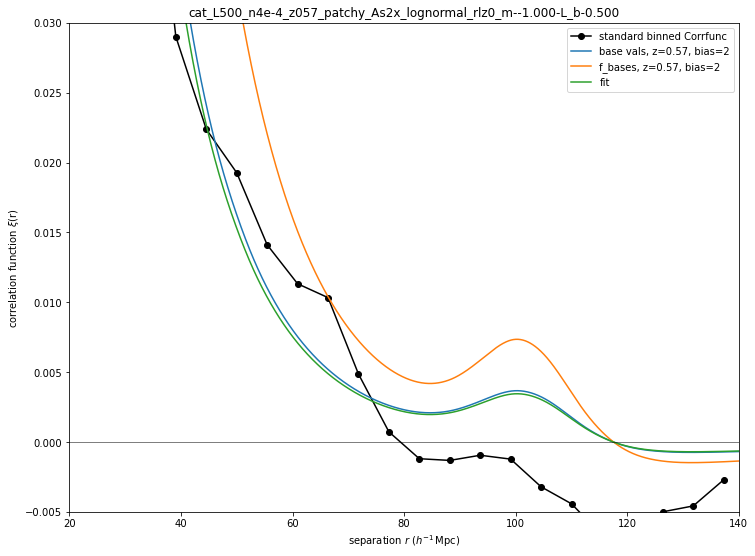

In [22]:
fig, ax = plt.subplots(figsize=(12,9))

plt.plot(r_avg, xi, "ko-", label="standard binned Corrfunc")
plt.plot(r_base, base_vals_z057_b2, label="base vals, z=0.57, bias=2")
plt.plot(r_base, f_bases_nograd(r_base), label="f_bases, z=0.57, bias=2")

plt.plot(r_base, theta.flatten()*f_bases_nograd(r_base), label="fit")

ax.set_title(mock_file_name_list[rlz])
ax.set_xlim(20, 140)
ax.set_ylim(-.005, 0.03)
plt.axhline(0, color="k", alpha=0.5, lw=1)
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'correlation function $\xi$(r)')
plt.legend()

#### new standard binned fit: mean + std for all mocks

In [28]:
mean_xi = np.mean(xi_full_patches, axis=0)
std_xi = np.std(xi_full_patches, axis=0)

In [31]:
# fit for all 401 mocks
nmocks = 401
thetas = np.zeros(nmocks)
for rlz in range(0, nmocks):
    theta, _ = fit_to_bases(rlz, r_avg, xi_full_patches)
    thetas[rlz] = theta

In [36]:
mean_theta = np.mean(thetas)
std_theta = np.std(thetas)

mean_fit = mean_theta*f_bases_nograd(r_base)
std_fit = std_theta*f_bases_nograd(r_base)

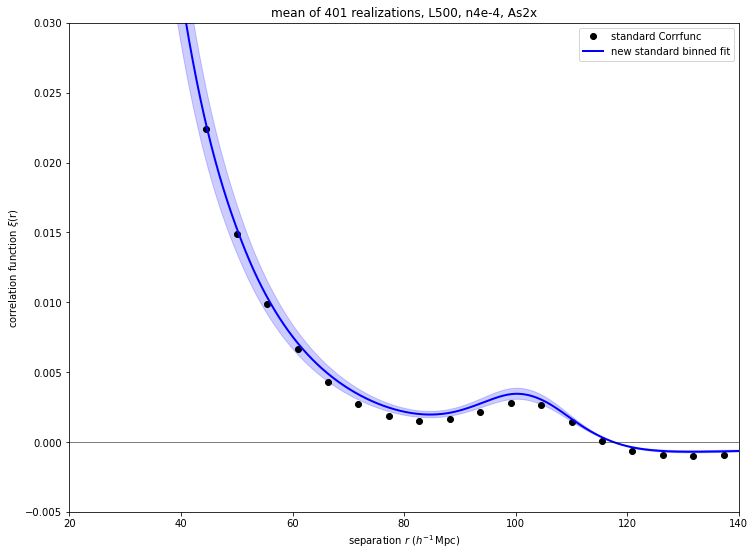

In [57]:
fig, ax = plt.subplots(figsize=(12,9))

plt.plot(r_avg, mean_xi,"ko", lw=1, label="standard Corrfunc")
plt.plot(r_base, mean_fit, color="b", lw=2, label="new standard binned fit")
ax.fill_between(r_base, mean_fit+std_fit, mean_fit-std_fit, color="b", alpha=0.2)

ax.set_title("mean of 401 realizations, L500, n4e-4, As2x")
ax.set_xlim(20, 140)
ax.set_ylim(-.005, 0.03)
plt.axhline(0, color="k", alpha=0.5, lw=1)
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'correlation function $\xi$(r)')
plt.legend()